# Creating a basic image classification model

### import required modules 

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers


Select category for image classification and set the data dir to this category

In [27]:
import pathlib

category = 'graphic-style'

data_dir = pathlib.Path(f'./data/{category}/')

count number of images

In [28]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27


set variables

In [29]:
batch_size = 32
img_height = 180
img_width = 180

setup training data set from category data directory

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28 files belonging to 2 classes.
Using 23 files for training.


setup validation data set

In [31]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28 files belonging to 2 classes.
Using 5 files for validation.


show classes

In [32]:
class_names = train_ds.class_names
print(class_names)

['Pixel', 'Realistic']


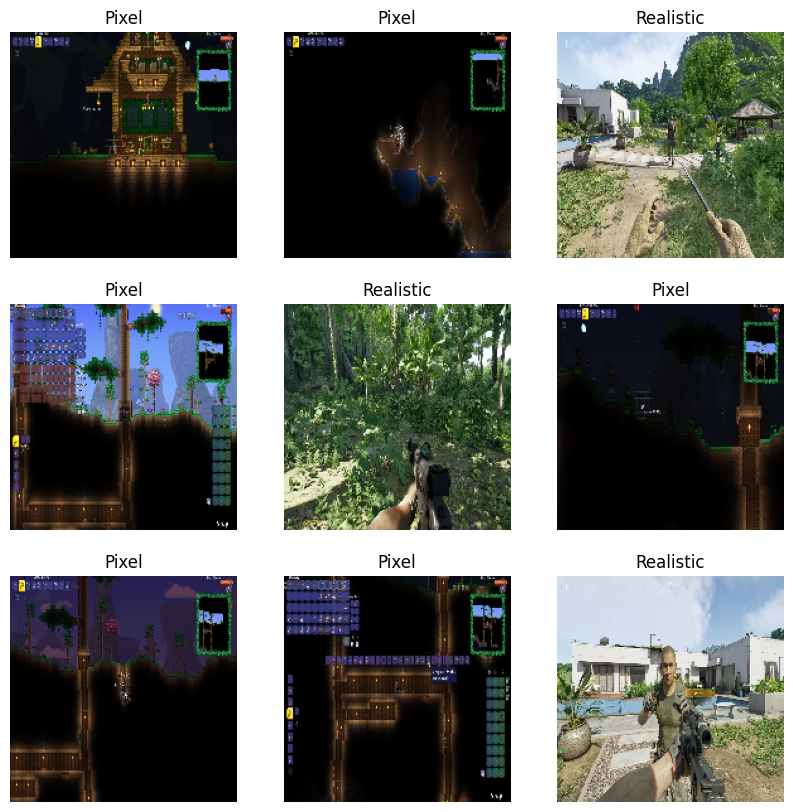

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(23, 180, 180, 3)
(23,)


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

scale images to between 0 - 1

In [36]:
normalization_layer = layers.Rescaling(1./255)

In [37]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


distort images to decrease overfitting

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

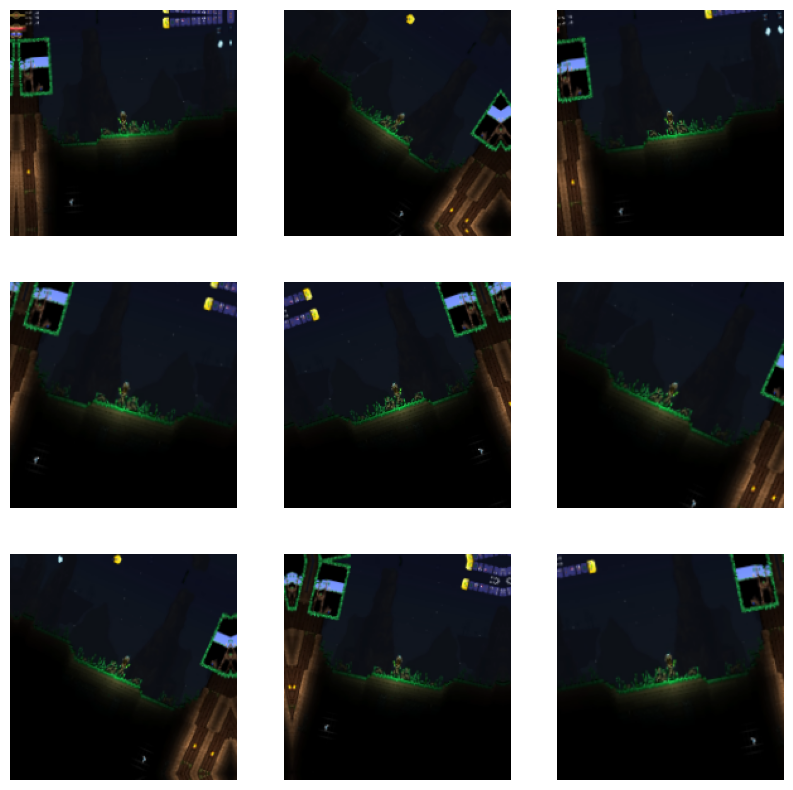

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model

Create a sequential model

In [40]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
  layers.Dense(num_classes, name="outputs")
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train model

In [43]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5217 - loss: 3.2677 - val_accuracy: 0.2000 - val_loss: 4.3501
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3913 - loss: 3.4672 - val_accuracy: 0.8000 - val_loss: 2.5643
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8696 - loss: 2.5238 - val_accuracy: 0.8000 - val_loss: 2.2517
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6087 - loss: 2.4055 - val_accuracy: 1.0000 - val_loss: 1.9928
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9130 - loss: 2.0085 - val_accuracy: 0.8000 - val_loss: 1.8957
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9130 - loss: 1.7355 - val_accuracy: 0.8000 - val_loss: 1.7501
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8696 - loss: 1.5819 - val_accuracy: 0.8000 - val_loss: 1.4534
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9130 - loss: 1.3762 - val_accuracy: 1.0000 - val_loss: 1.1907
Ep

### Model accuracy summary

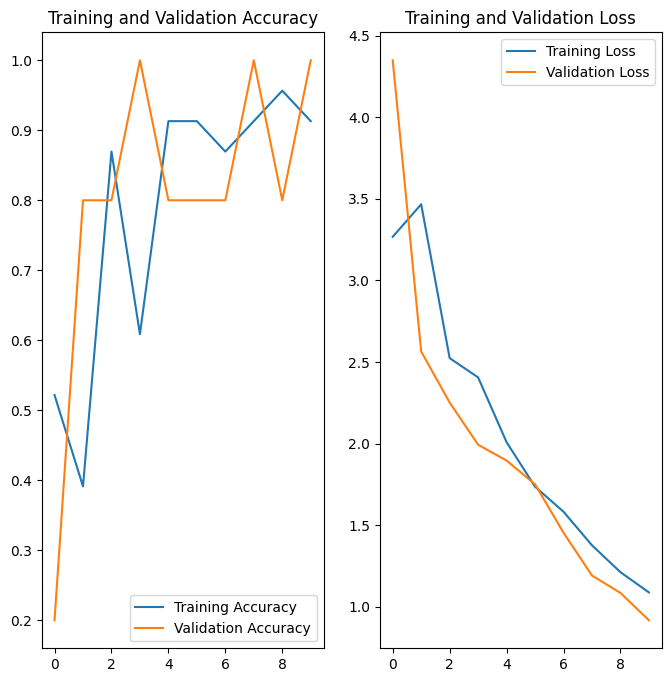

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Test model

Use an image path to evaluate the class of the image

In [45]:
test_path = pathlib.Path('./examples/example1.png')

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
This image most likely belongs to Pixel with a 93.71 percent confidence.


save the model using the category name

In [46]:
model.save(f'./models/{category}-classifier.keras')

load a previous model

In [47]:
new_model = tf.keras.models.load_model(f'./models/graphic-style-classifier.keras')

# Show the model architecture
new_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,966,696 (45.65 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,977,798 (30.43 MB)

predict class using loaded model

In [48]:
test_path = pathlib.Path('./examples/example1.png')

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
This image most likely belongs to Pixel with a 93.71 percent confidence.
